In [1]:
import pandas as pd
import numpy as np
import warnings
import regex as re
warnings.filterwarnings('ignore')

import pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score #el report nos ayuda a ver un resumen mejor de los datos
from sklearn.metrics import mean_squared_error as mse

In [2]:
data = pd.read_csv('../data/data_eda_1.csv')

In [3]:
# Codificación de la variable categórica 'Type' usando codificación One-Hot-Encoing
data_encoded = pd.get_dummies(data, columns=["Type"], drop_first=True)
data_encoded.head()

,Time_hour,Amount,Origin_ID,Old_balance_Org,New_balance_Org,Destination_ID,Old_balance_Dest,New_balance_Dest,Fraud,Flagged_Fraud,Type_CASH_OUT,Type_DEBIT,Type_PAYMENT,Type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,1,0


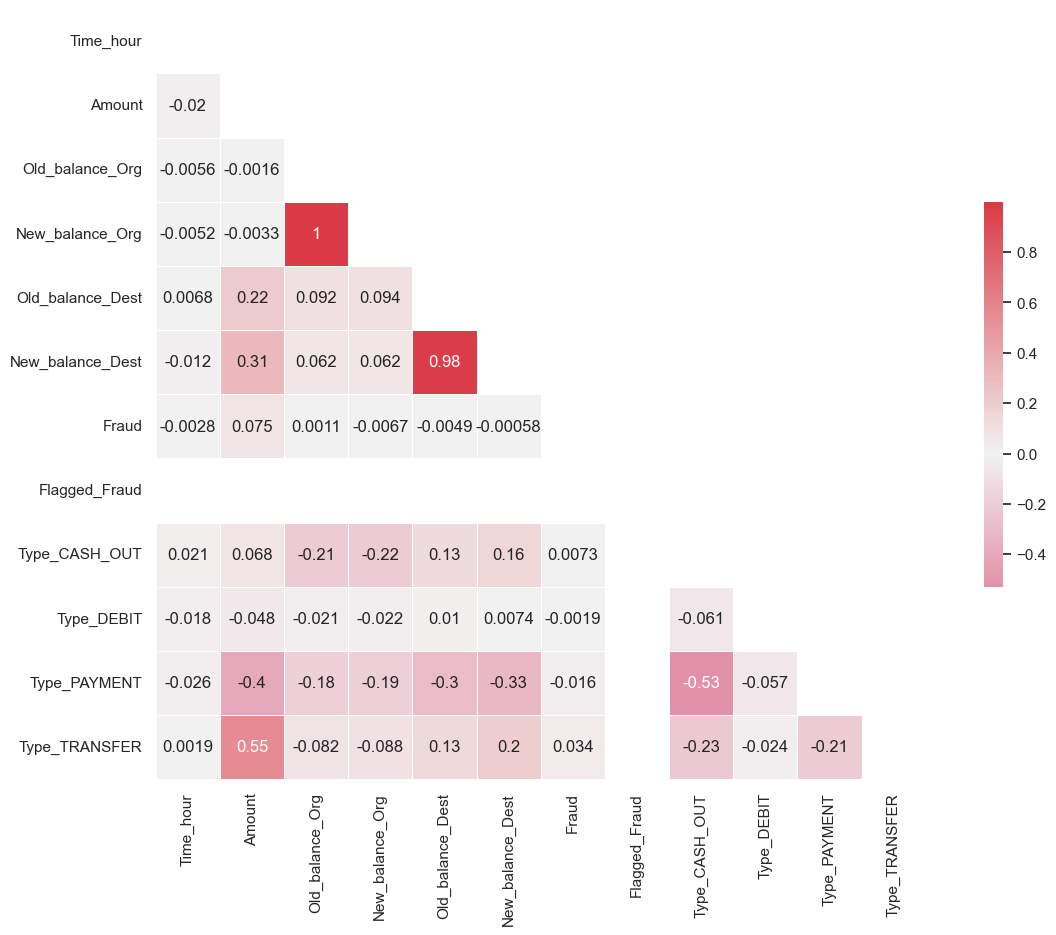

In [4]:
plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(data_encoded.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(data_encoded.corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

In [5]:
# Balanceado de los datos. Undersampling
data_encoded['Fraud'].value_counts()

0    999465
1       535
Name: Fraud, dtype: int64

In [6]:
data_majority = data_encoded[data_encoded.Fraud == 0]
data_minority = data_encoded[data_encoded.Fraud == 1]
data_majority_downsampled = data_majority.sample(n=len(data_minority))
data_downsampled = pd.concat([data_majority_downsampled, data_minority])
data_downsampled.shape

(1070, 14)

## Empezamos a entrenar

In [7]:
#Empezamos con todos las columnas posibles.
X = data_downsampled.drop(['Fraud', 'Origin_ID', 'Destination_ID', 'Flagged_Fraud'], axis=1)
#Decidí quitar Old_balance_Org y Old_balance_Dest por la colinealidad pero me empeoró el resultado.
y = data_downsampled['Fraud']

In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test

(        Time_hour      Amount  Old_balance_Org  New_balance_Org  \
 792109         40    26950.06         26950.06              0.0   
 107758         10   261057.64             0.00              0.0   
 48998           9    70594.64             0.00              0.0   
 368259         17  1639676.27       1639676.27              0.0   
 925777         43      925.67             0.00              0.0   
 ...           ...         ...              ...              ...   
 505912         20     1539.91             0.00              0.0   
 572854         24     6844.73          6844.73              0.0   
 4104            3    10539.37         10539.37              0.0   
 576342         30   122235.11        122235.11              0.0   
 713016         37     3160.70             0.00              0.0   
 
         Old_balance_Dest  New_balance_Dest  Type_CASH_OUT  Type_DEBIT  \
 792109              0.00              0.00              0           0   
 107758        3704306.12        4

## 1. Regresión Logística

In [9]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
print("Reporte Regresión Logística:\n", classification_report(y_test, logistic_predictions))

Reporte Regresión Logística:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       161
           1       0.88      0.93      0.90       160

    accuracy                           0.90       321
   macro avg       0.90      0.90      0.90       321
weighted avg       0.90      0.90      0.90       321



## 2. Arbol de decisión

In [10]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_predictions = tree_model.predict(X_test)
print("Reporte Árbol de Decisión:\n", classification_report(y_test, tree_predictions))

Reporte Árbol de Decisión:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       161
           1       0.96      0.95      0.95       160

    accuracy                           0.95       321
   macro avg       0.95      0.95      0.95       321
weighted avg       0.95      0.95      0.95       321



In [11]:
mse(y_test, tree_predictions, squared=False)  # rmse

0.21616885058355845

## 3. Random Forest

In [12]:
forest_model = RandomForestClassifier(random_state=42)
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
print("Reporte Bosque Aleatorio:\n", classification_report(y_test, forest_predictions))

Reporte Bosque Aleatorio:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       161
           1       0.97      0.96      0.97       160

    accuracy                           0.97       321
   macro avg       0.97      0.97      0.97       321
weighted avg       0.97      0.97      0.97       321



In [13]:
mse(y_test, forest_predictions, squared=False)  # rmse

0.17650112740455196

este es el mejor modelo y tiene una precisión y sensibilidad del 97% de aciertos. 

## A partir de aquí vamos a visualizar los resultado de mi random forest.

In [14]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import roc_auc_score as auc

## Matriz de confusión

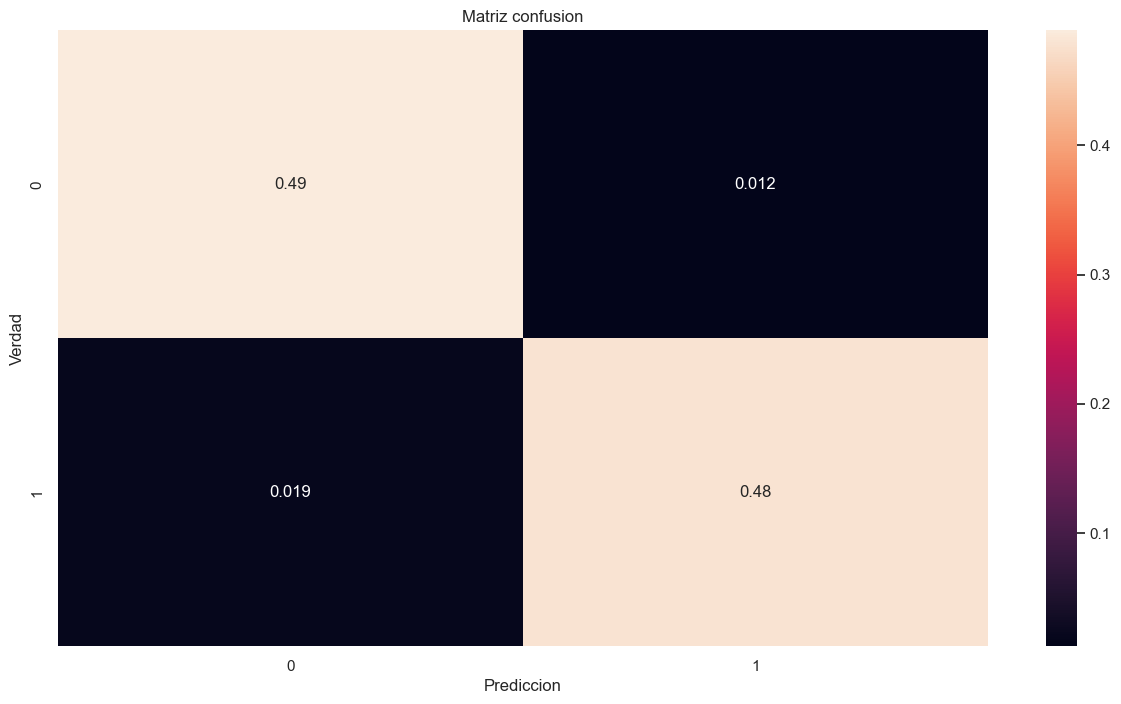

In [15]:
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, forest_predictions)/cm(y_test, forest_predictions).sum(), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [16]:
cm(y_test, forest_predictions)

array([[157,   4],
       [  6, 154]])

+ Verdadero no fraude: 157
+ Falso fraude: 4
+ Falso no fraude: 6. Para afinar el modelo deberíamos hacer que este resultado tienda más a un falso positivo (falso fraude) en este tipo de datos concretamente. Veremos si no aumenta al entrenar el modelo con todos los datos.
+ Verdadero fraude: 154

In [19]:
forest_prob = forest_model.predict_proba(X_test)[:,1]
forest_prob[:5]

array([1.  , 0.  , 0.7 , 0.03, 0.17])

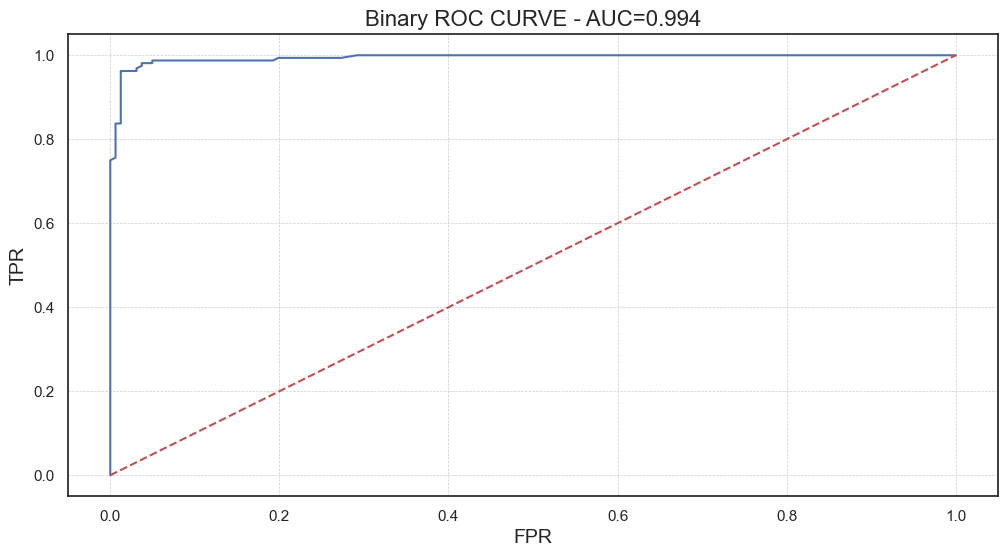

In [31]:
plt.figure(figsize=(12, 6))

fpr, tpr, _ = roc(y_test, forest_prob)   

a=auc(y_test, forest_prob)

plt.plot(fpr, tpr)

plt.plot(fpr, fpr, 'r--')

plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)

plt.title('Binary ROC CURVE - AUC={:.3f}'.format(a), fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show();